# Soft clustering of audio using LDA and bag-of-audio words

If you find yourself in a situation where you have a massive amount of audio that you would like to somehow categorize, you might be tempted at doing clustering. However, an audio sample might contain more than one kind of sound, so putting it in a single cluster might not be warranted. Latent Dirichlet Allocation (LDA) is an unsupervised "clustering" algorithm, often applied to text, that allows you to describe a datapoint (called a "document") as a sparse combination of "basis documents". Each basis document, in turn, is a sparse combination of "words". In the audio context, we do not really have a well-defined notion of a word, but we can invent such a notion. In this notebook, an audio word is a frequency component. An "audio document" is thus made up out of "frequency terms". This will allow us to run LDA on a set of audio samples. The dataset I use is rather large, so I will not upload it to github, I can however share it with you in case you do not have a suitable dataset yourself. The dataset is made up out of 3000 short (~0.6s) audio clips of bird calls.

We start by defining a function to load the data.

In [1]:
using Glob, WAV, Serialization, TextAnalysis, SparseArrays, Peaks, AMD
using Grep
using DSP, LPVSpectral
using AudioClustering, SpectralDistances

const fs = 44100 # sample rate
const minpeak = 1e-6 # the minimum power to cinsider in a spectrum

function get_audio_words(path, load_from_disc=true)

    cd(path)
    files = glob("*.wav")
    labels0 = match.(r"[a-z_]+", files)..:match .|> String
    ulabels = unique(labels0)
    labels = sum((labels0 .== reshape(ulabels,1,:)) .* (1:30)', dims=2)[:]
    M = mel(fs, 512)
    if !load_from_disc # process and save all files
        models = mapsoundfiles(files) do sound
            sound = vec(sound[findfirst(!iszero, sound):findlast(!iszero, sound)])
            sound = SpectralDistances.bp_filter(sound, (50/fs, 18000/fs))
            P = welch_pgram(sound, 512, fs=fs)
            spectral_fingerprint(M,P)
        end;
        serialize("audiowords", models)
    else
        models = deserialize("audiowords")
    end

    labels,models
end

get_audio_words (generic function with 2 methods)

The "words" we'll use will be the frequencies of peaks in the spectrum of the audio clip. The function below extract those peaks, their location and hight.

In [2]:
function spectral_fingerprint(M,P, l = 8)
    power = M*P.power     # Transform to a Mel spectrum
    power ./= std(power)
    p,prom = peakprom(power, Maxima(), 7, minpeak)
    perm = sortperm(prom, rev=true)

    p = p[perm[1:min(l, length(p))]]
    (p, power[p])
end

spectral_fingerprint (generic function with 2 methods)

Now, we are ready to load the data and calculate the features.

In [4]:
path = "/home/fredrikb/kokulbirds/test_padded_30birds/"
labels,words = get_audio_words(path,true);

We are now ready to run LDA. The algorithm takes three parameters, the number of topics and two parameters related to the sparsity of the topics and "documents". The function `lda` expects a special data structure, `DocumentTermMatrix` as input, so we create that first.

In [ ]:
n_terms = 128 # The number of terms in the dictionary is the number of mel-frequencies in the spectra
n_docs = length(words)
terms = collect(1:n_terms) # We enumerate the terms starting from 1
inner_dtm = spzeros(Int, n_docs, n_terms)

for di in 1:n_docs     # Populate the document term matrix
    for (ti, tc) in zip(words[di]...)
        inner_dtm[di,ti] = round(Int, log10.(tc/minpeak))
    end
end

dtm = DocumentTermMatrix(inner_dtm,terms)

ntopics   = 60      # We choose 60 topics, even though we know there are 30 classes in the "corpus"
iteration = 1000
α = 0.1/ntopics # Dirichlet dist. hyperparameter for topic distribution per document. `α<1` yields a sparse topic mixture for each document. `α>1` yields a more uniform topic mixture for each document.
β = 0.01 # Dirichlet dist. hyperparameter for word distribution per topic. `β<1` yields a sparse word mixture for each topic. `β>1` yields a more uniform word mixture for each topic.

ϕ, θ = lda(dtm, ntopics, iteration, α, β);

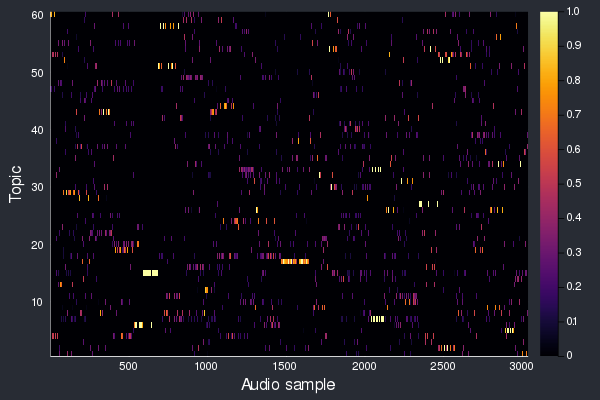

In [15]:
heatmap(θ, xlabel="Audio sample", ylabel="Topic")

It takes a while to run this algorithm, should be done in a minute or so. The result is two matrices
- `ϕ`: `ntopics × nwords` Sparse matrix of probabilities s.t. `sum(ϕ, 1) == 1`
- `θ`: `ntopics × ndocs` Dense matrix of probabilities s.t. `sum(θ, 1) == 1`
The heatmap of `θ` indicates what topics are ascribed to each "document" (audio sample). You should be able to see clusters of bright spots in this image, it's because the audio samples were sorted by class. In reality this picture would look very scrambled and the analysis below would be needed to find similar samples.

Next, we investigate the correlation between different topics based on both which words they contain and which audio samples contained the topics.

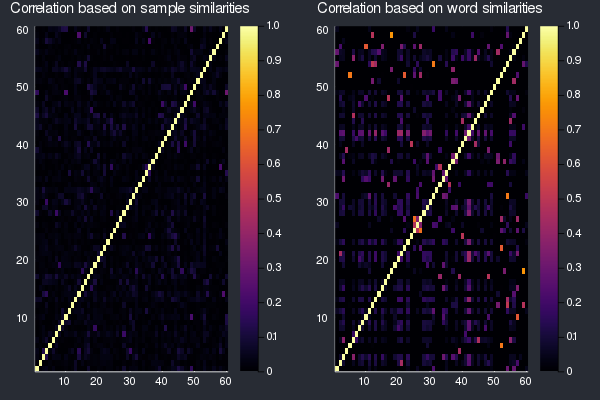

In [10]:
function corr(x::AbstractMatrix)
    d = diag(x)
    y = copy(x)
    for i = 1:length(d), j = 1:length(d)
        y[i,j] /= sqrt(x[i,i]*x[j,j])
    end
    y
end
topic_cov_by_words   = Matrix(ϕ*ϕ')
topic_cov_by_sample  = Matrix(θ*θ')
topic_corr_by_words  = corr(topic_cov_by_words)
topic_corr_by_sample = corr(topic_cov_by_sample)

plot(
    heatmap(topic_corr_by_sample, title="Correlation based on sample similarities", titlefont=10),
    heatmap(topic_corr_by_words, title="Correlation based on word similarities", titlefont=10)
)

Bright off-diagonal spots in the images above indicate that two topics share something in common.

To find an average topic vector for each class, we average over all the class samples. We can do this since we have class labels associated with the samples. In practice, this might be much harder.

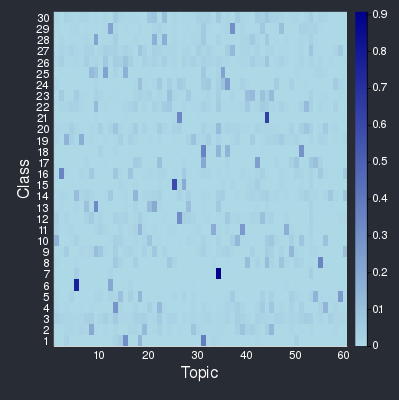

In [11]:
ulabels = unique(labels)
classvecs = map(ulabels) do label
    classinds = findall(labels .== label)
    vec(mean(θ[:,classinds], dims=2))
end
classvecs = reduce(hcat,classvecs) # n_topics × n_class
heatmap(classvecs',yticks=(1:length(ulabels), ulabels), xlabel="Topic", ylabel="Class", size=(400,400), color=:blues)

We can also try to find similarities between classes based on which topics are occuring for samples within the class. To make it easier to spot the similarities, we run an AMD algorithm on the similarity matrix, so that similar classes are likely to be placed next to each other. 

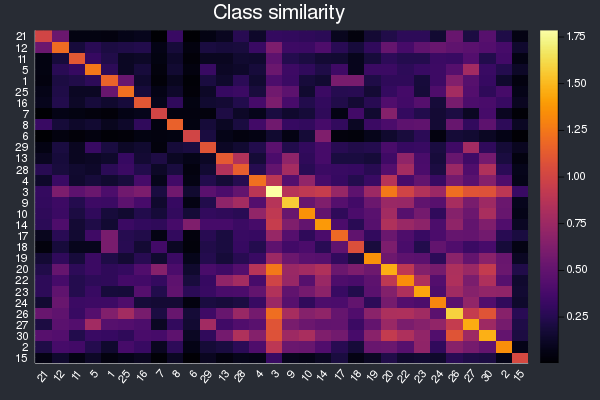

In [12]:
function diagonalize(C, tol=:auto; permute_y=false, doplot=false)
    C = copy(C)
    amdmat = size(C,1) == size(C,2) ? copy(C) : C'C
    # amdmat = C'C
    if tol === :auto # Find tolerance automatically (adhoc)
        y    = abs.(amdmat[:])
        inds = sortperm(y)
        cum  = cumsum(y[inds])
        cum ./= cum[end]
        i    = findfirst(c->c > 0.3, cum)
        tol  = y[inds[i]]
    end
    doplot && (histogram(abs.(amdmat[:])) |> display)
    amdmat[abs.(amdmat) .< tol] .= 0
    perm  = amd(sparse(amdmat))
    yperm = permute_y ? perm : 1:size(C,1)
    C[yperm,perm], perm, yperm
end
function plotcov(C, xvector, yvector; kwargs...)
    xticks = (1:length(xvector), xvector)
    yticks = (1:length(yvector), yvector)
    heatmap(C; xticks=xticks, yticks=yticks, xrotation=50, title="Class similarity", kwargs...)
end

classvecs_unit = mapslices(v-> v./norm(v), classvecs, dims=1)
classcov = classvecs_unit'topic_corr_by_sample*classvecs_unit

C, perm, yperm = diagonalize(classcov, permute_y=true)
plotcov(C,ulabels[perm],ulabels[perm], yflip=true)

The figure indicates that class 21 and 12 are similar, and that class 3 is similar to many other classes. Class 15 is very unique.